In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging



In [2]:
# Defining anything I want to keep the same 

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)


#basedir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/'
basedir = '/hirax/GBO_Analysis_Outputs/'
fitdir=basedir+'main_beam_fits/'
ymldir = basedir+'concat_config_files/'
pckldir = basedir+'flight_pickles/'
ampdir = basedir+'amplitude_corrections/'
beamdir = basedir+'beam_pickles/'

dronedir='/hirax/all_drone_data/datcon_csv/'

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))

Npolflights = ['618','619','623','625','646','647','533','536']
Epolflights = ['620','648','649','535']
NF = len(Npolflights)
NE = len(Epolflights)
F = NF+NE
fi_i =650

colormap='viridis'





In [3]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

In [4]:
for fly in flights[0:2]:
    if fly!='618' and fly!='620':
        print(fly)

533
534


In [5]:
for fly in flights:
    ampls = np.zeros([4,1024,16])
    if fly!='618' and fly!='620':
        ampfiles = np.sort(glob.glob(ampdir+'ampsubfiles/'+'*'+fly+'*'))
        for ffile in ampfiles:
            #print('Loading: ',ffile)
            with open(ffile, 'rb') as inp:
                amps = pickle.load(inp)
                noz = np.where(np.nanmean(amps[0,:,:],axis=-1)!=0)[0]
                ampls[:,noz,:] = amps[:,noz,:]
    
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        print(pklfile)
        with open(pklfile, 'wb') as outp:
            pickle.dump(ampls, outp, pickle.HIGHEST_PROTOCOL)
print('DONE')

/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY533_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY534_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY535_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY536_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY619_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY623_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY625_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY646_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY647_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY648_Corrected_amplitudes.pkl
/hirax/GBO_Analysis_Outputs/amplitude_corrections/FLY649_Corrected_amplitudes.pkl
DONE


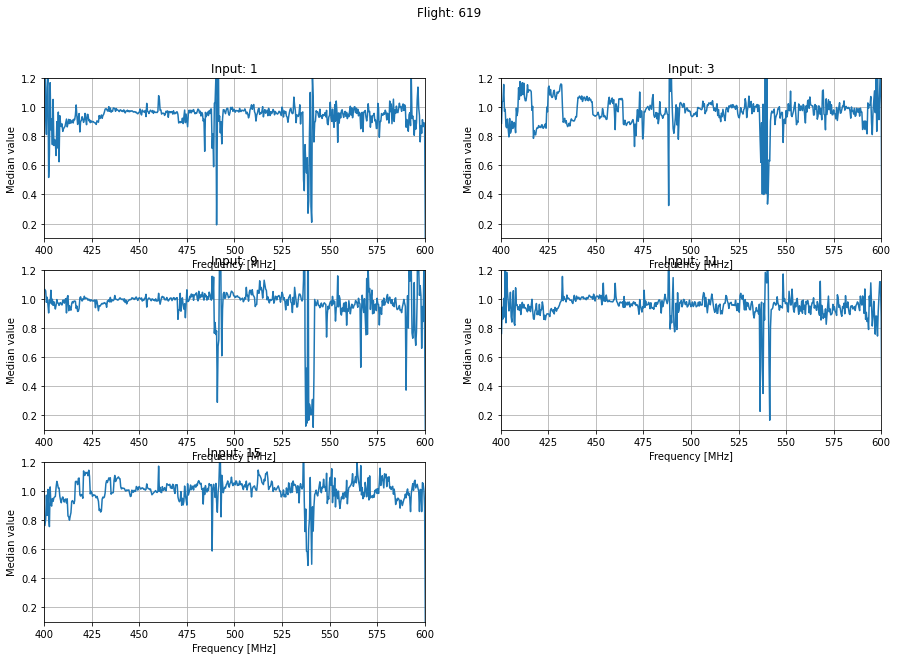

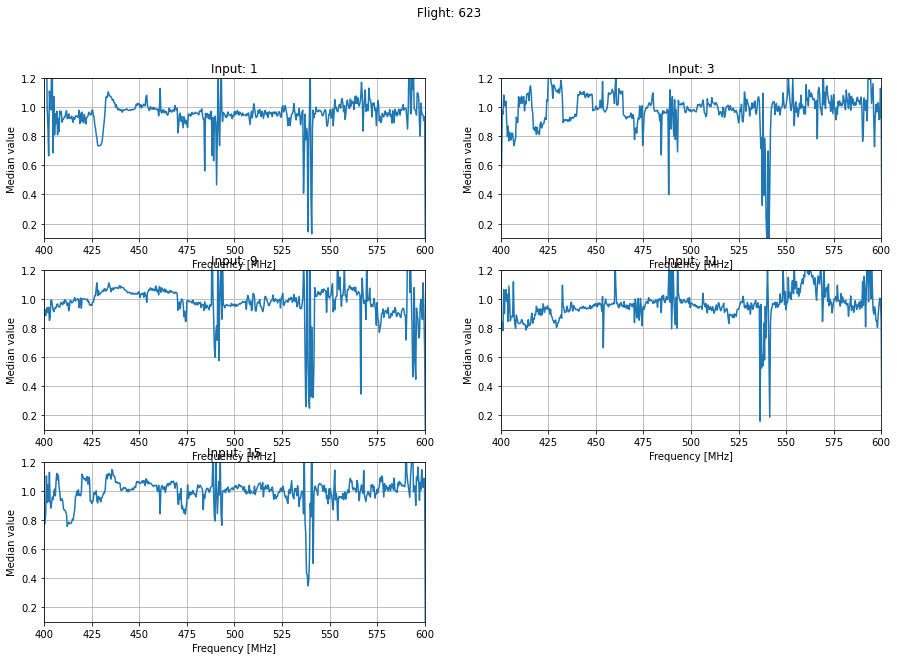

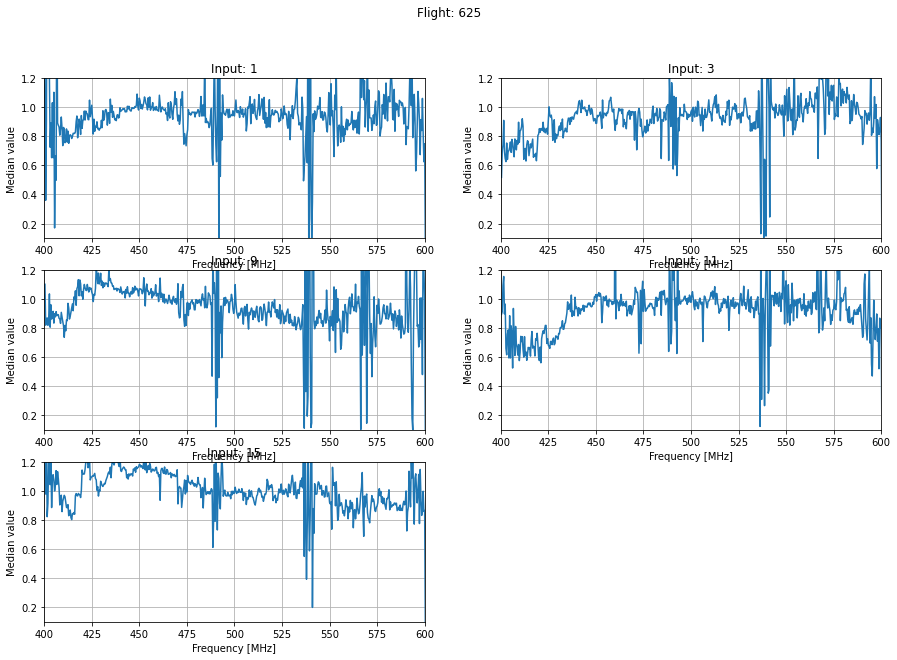

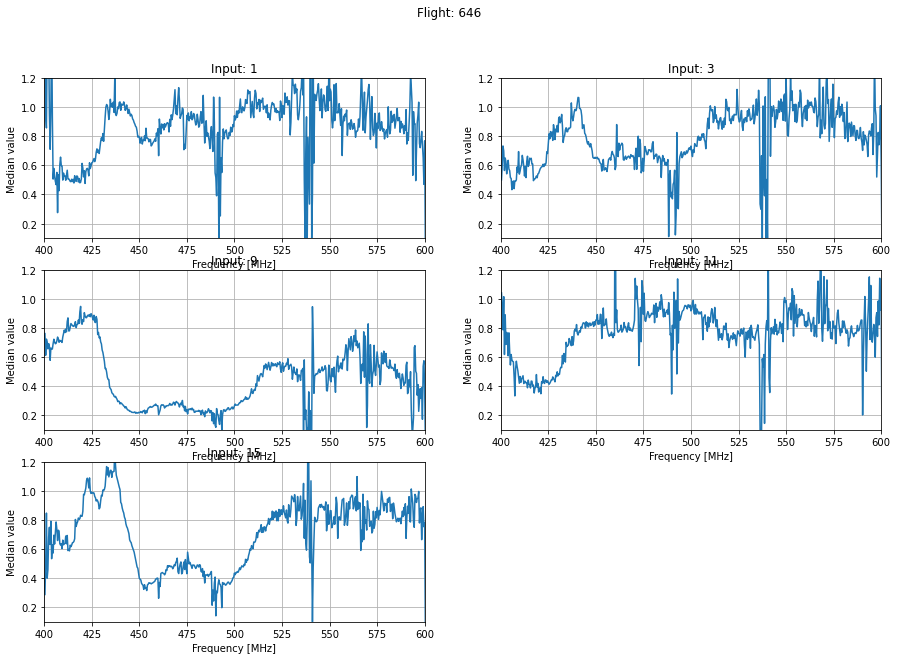

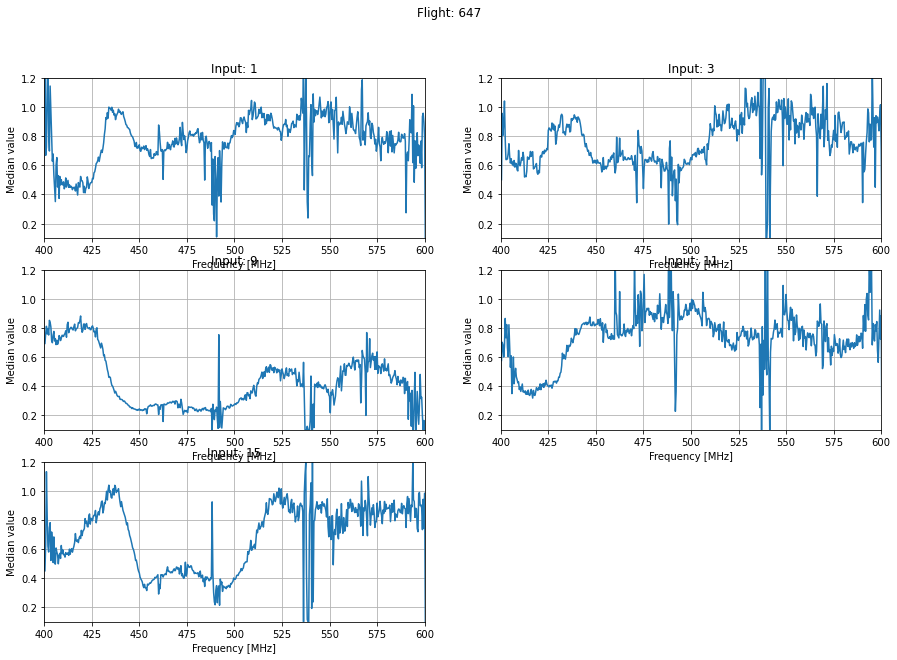

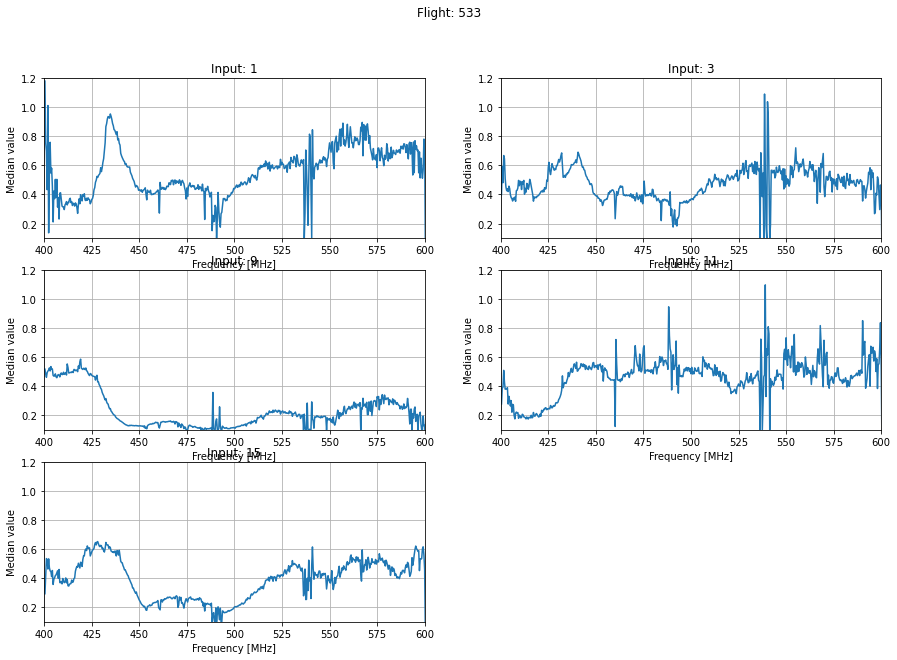

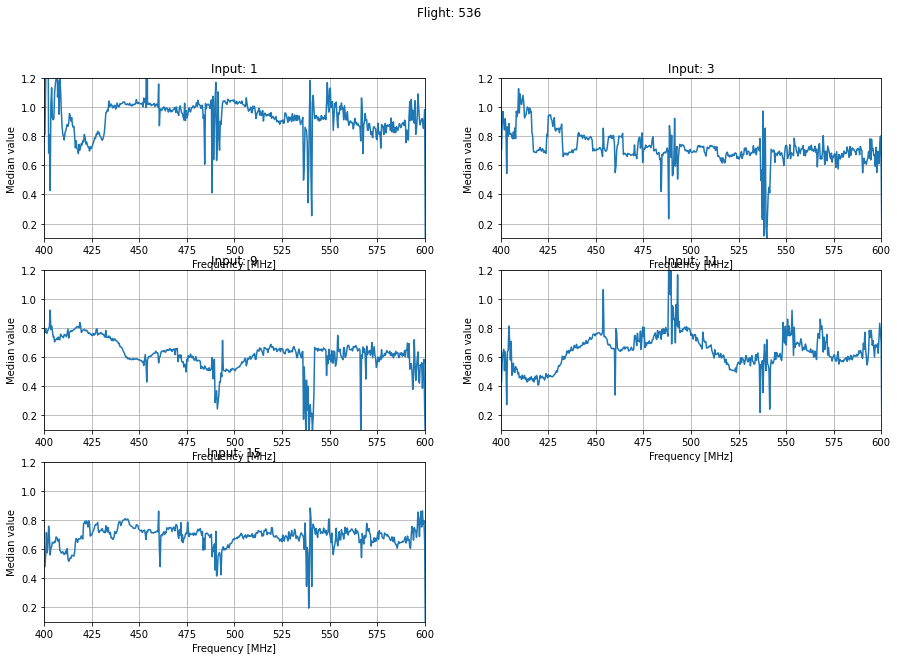

In [6]:
# Lets's start wi N pol:

for fly in Npolflights[1::]:
    amps = np.zeros([4,1024,16]) 
    pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
    with open(pklfile, 'rb') as inp:
        pamps = pickle.load(inp) 

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(N_pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,pamps[0,:,chind])
        plt.xlim(400,600)
        plt.ylim(0.1,1.2)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    


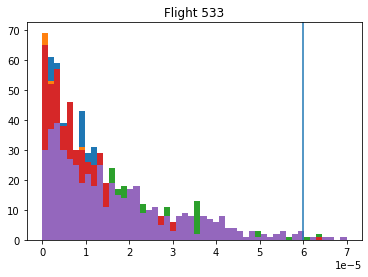

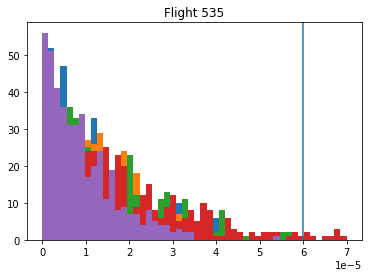

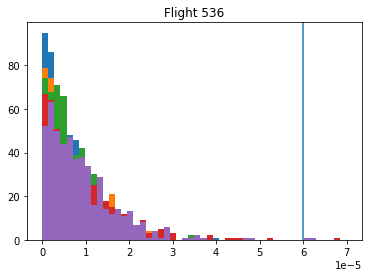

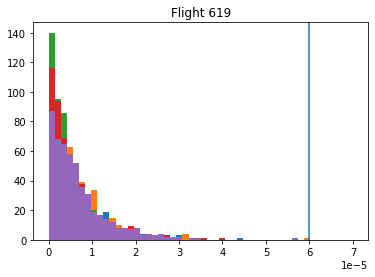

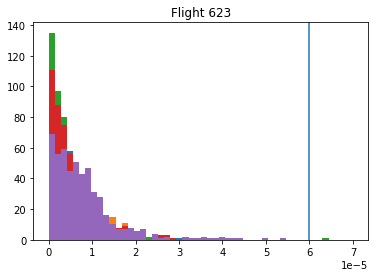

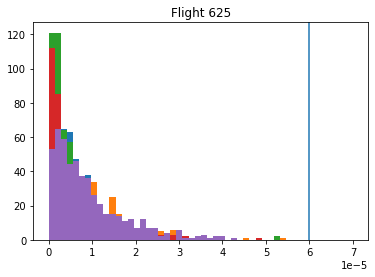

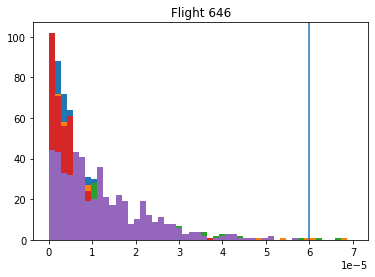

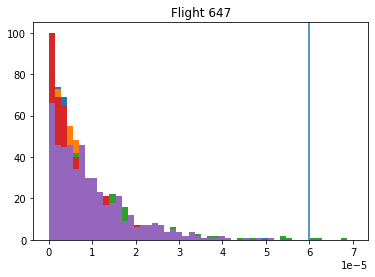

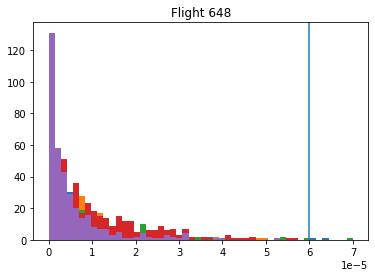

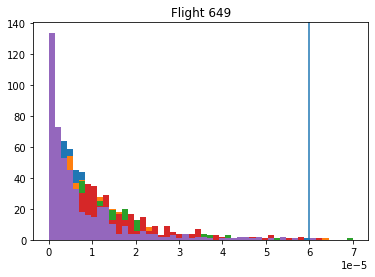

In [7]:
# get good frequencies

for fly in flights:
    if fly in Npolflights and fly!='618':
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            pamps = pickle.load(inp) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish


        for p in N_pols:
            plt.hist(pamps[1,512:1024,p],bins=50,range=[0,7E-5])
        plt.axvline(6E-5)
        plt.title('Flight '+fly)
        plt.show()
    elif fly in Epolflights and fly!='620':   
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            pamps = pickle.load(inp)


        for p in E_pols:
            plt.hist(pamps[1,512:1024,p],bins=50,range=[0,7E-5])
        plt.axvline(6E-5)
        plt.title('Flight '+fly)
        plt.show()

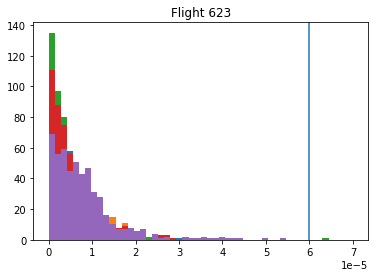

In [8]:
# Special, look at S pol flight 623

fly='623'
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    pamps = pickle.load(inp) # stat [best amp value from median, median value at min, best from stdd, best from mean], freq, dish


for p in N_pols:
    plt.hist(pamps[1,512:1024,p],bins=50,range=[0,7E-5])
plt.axvline(6E-5)
plt.title('Flight '+fly)
plt.show()

In [19]:
# Find good frequencies
# in paper, that was noted as any where ALL flights and dishes had a median value below 6E-5


In [9]:
# lets tally the frequencies we don't want to use
Nbadfreqs = []
Ebadfreqs = []

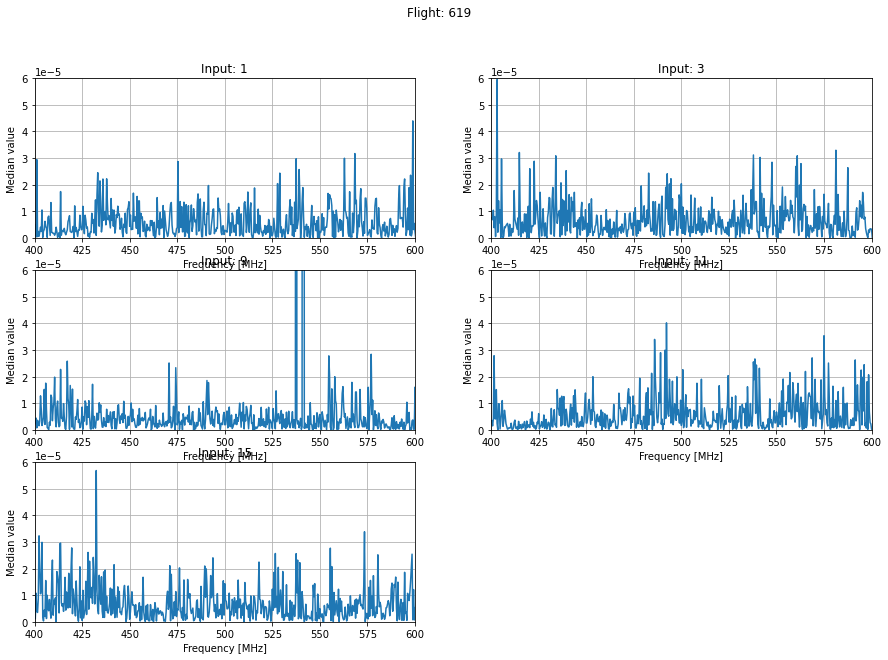

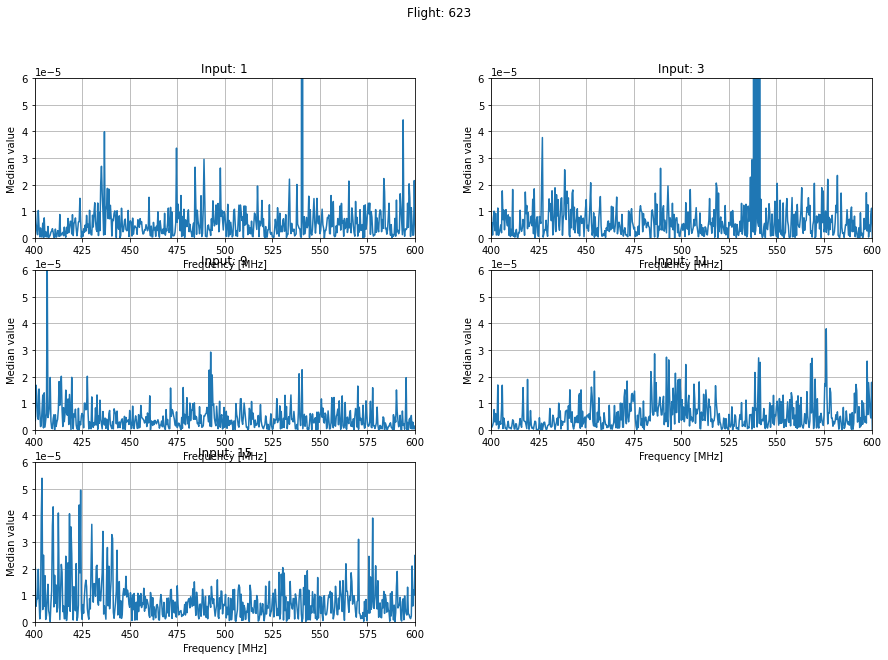

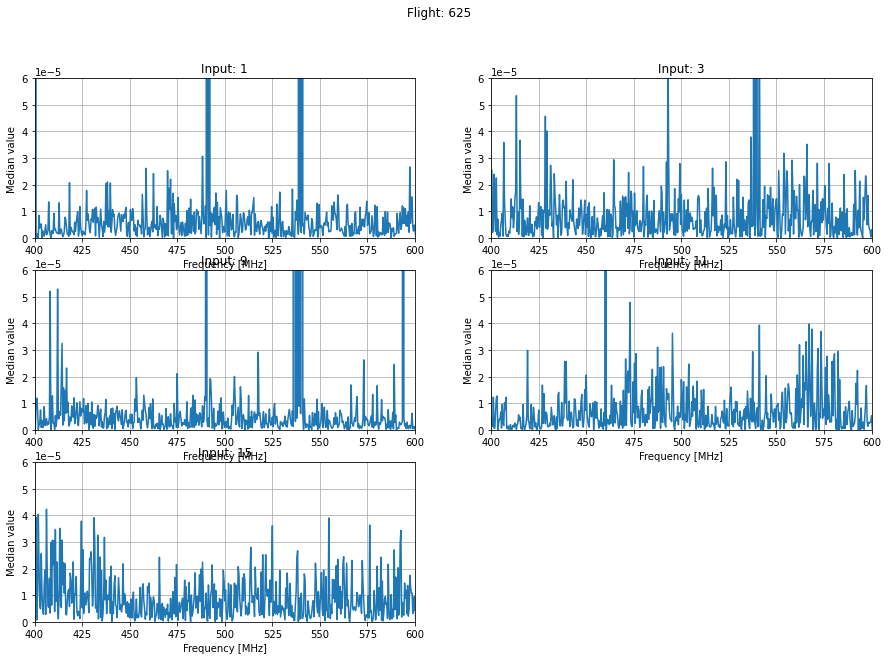

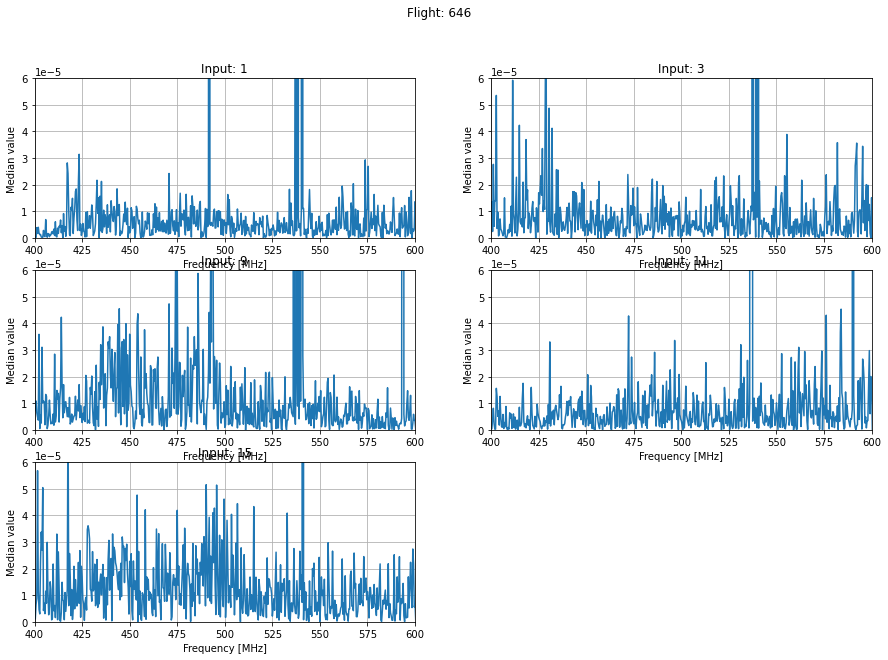

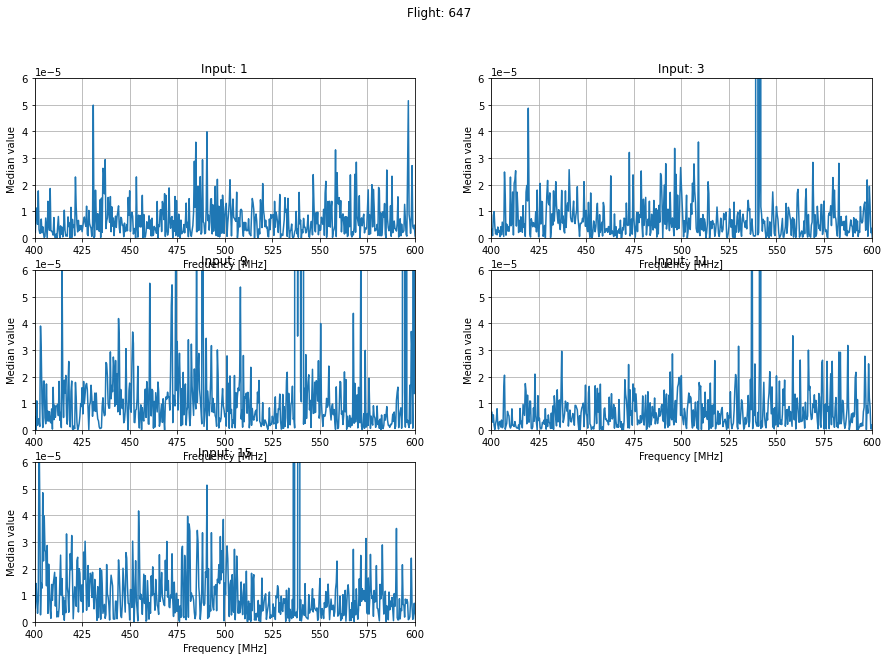

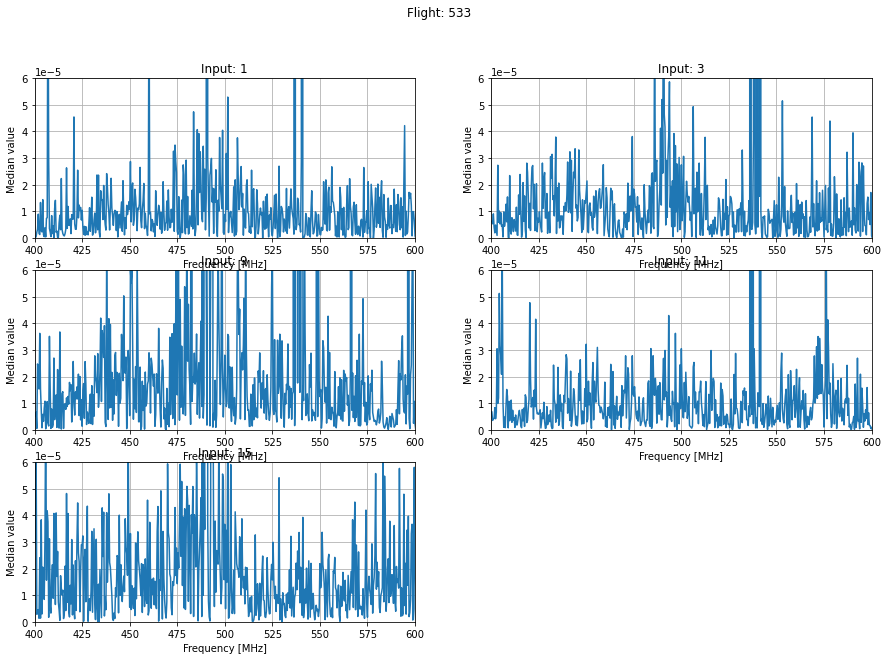

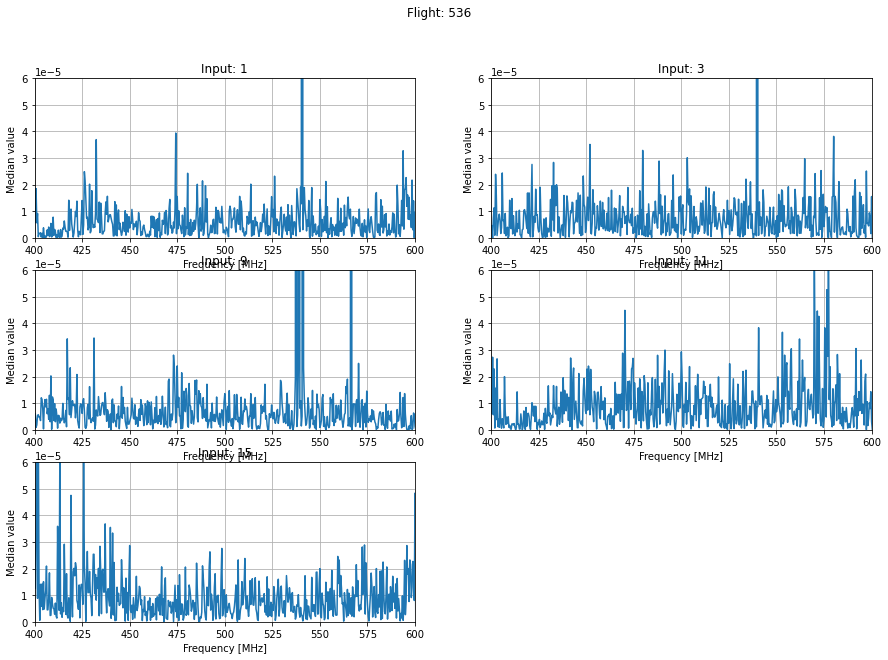

In [10]:
# Lets's start wi N pol:

for fly in Npolflights[1::]:
    amps = np.zeros([4,1024,16]) 
    pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
    with open(pklfile, 'rb') as inp:
        pamps = pickle.load(inp) 

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(N_pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,pamps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(N_pols):
        for g in np.arange(512,1024):
            if pamps[0,g,chind] == 0.1 or  pamps[0,g,chind] >2.8 or pamps[1,g,chind] >6E-5: Nbadfreqs.append(g)

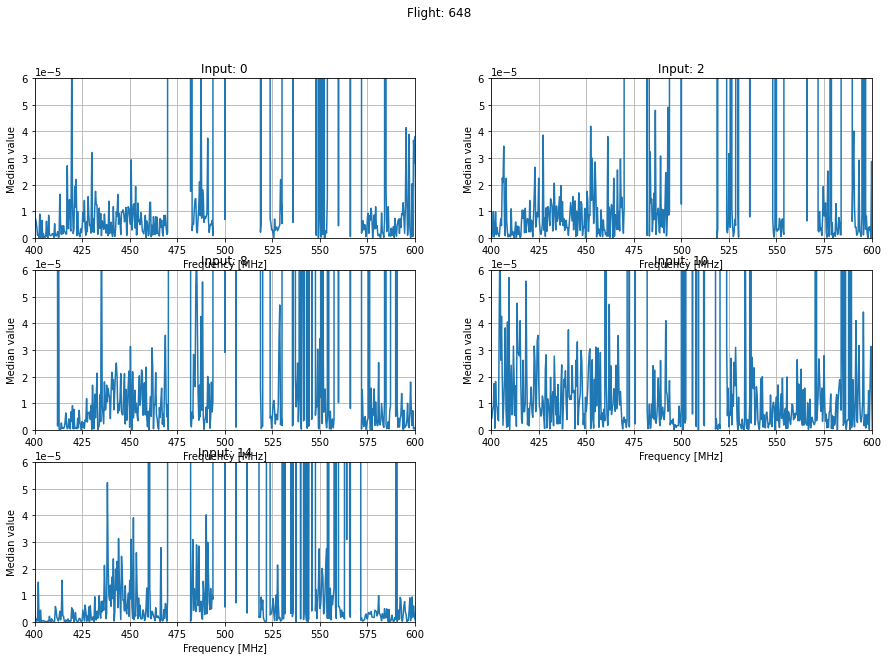

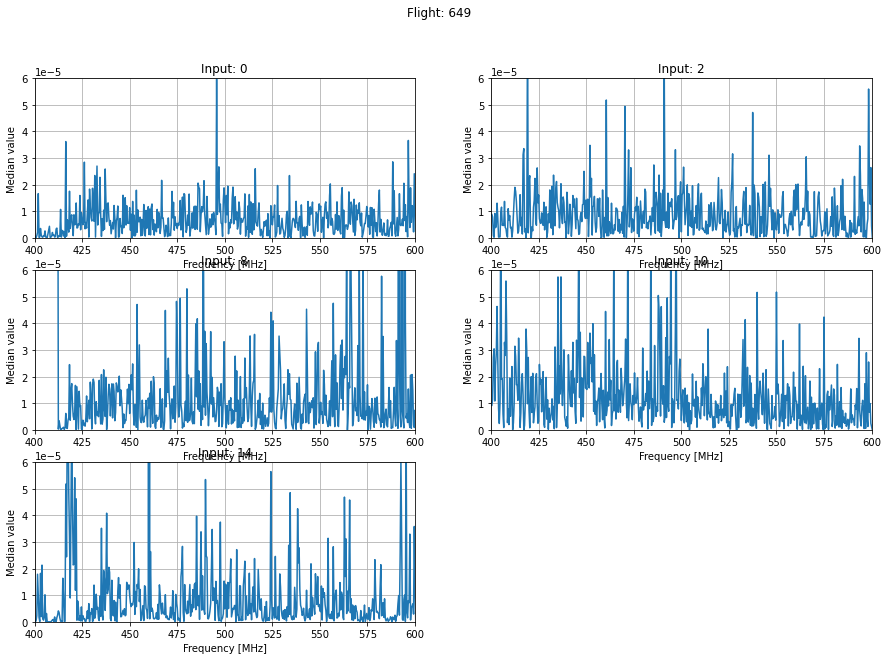

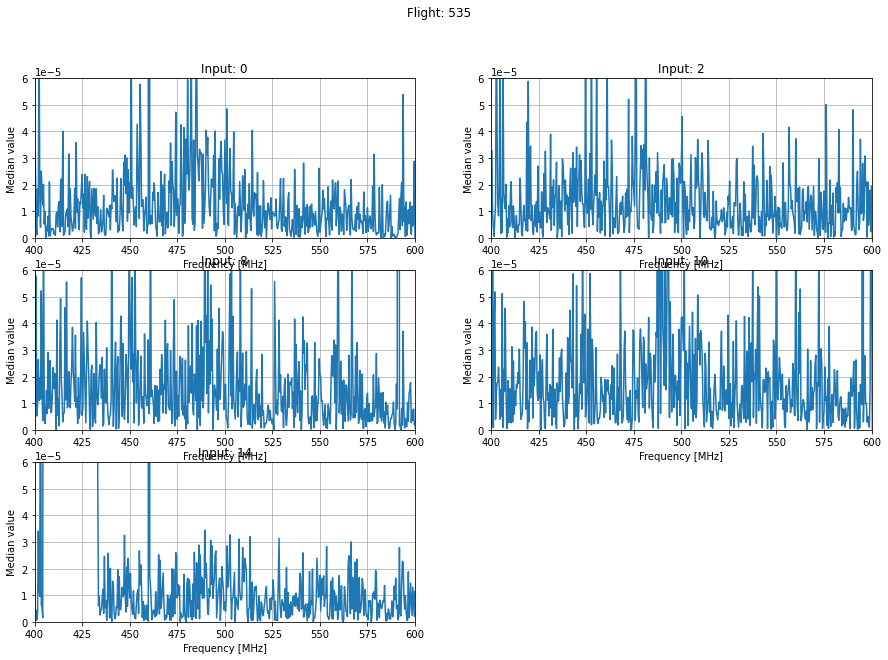

In [11]:
# Now E pol flights:
for fly in Epolflights[1::]:
    pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
    with open(pklfile, 'rb') as inp:
        pamps = pickle.load(inp) 

    fig = plt.figure(figsize=(15,10))
    for j, chind in enumerate(E_pols):
        plt.subplot(3,2,j+1)
        plt.plot(freqs,pamps[1,:,chind])
        plt.xlim(400,600)
        plt.ylim(0,6E-5)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Median value')
        plt.grid()
        plt.title('Input: '+str(chind))
    plt.suptitle('Flight: '+fly)
    plt.show()
    
    for j, chind in enumerate(E_pols):
        for g in np.arange(512,1024):
            if pamps[0,g,chind] == 0.1 or  pamps[0,g,chind] >2.8 or pamps[1,g,chind] >6E-5: Ebadfreqs.append(g)

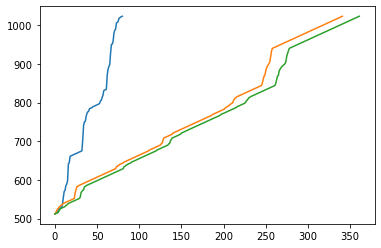

81 342 362
BAD FREQUENCY INDICES:  [ 512  513  514  515  516  521  524  526  527  528  529  530  531  534
  535  537  539  540  541  542  543  544  545  546  547  548  549  550
  551  552  555  567  570  573  574  582  583  585  586  587  588  589
  590  591  592  593  594  595  596  597  598  599  600  601  602  603
  604  605  606  607  608  609  610  611  612  613  614  615  616  617
  618  619  620  621  622  623  624  625  626  627  628  629  634  635
  637  638  640  641  642  643  644  646  647  648  649  650  651  652
  653  654  655  656  657  658  659  660  661  662  663  664  665  666
  667  668  669  670  671  672  673  674  675  677  678  679  680  681
  682  683  684  685  686  687  688  689  690  693  694  701  704  708
  709  710  711  712  713  714  715  716  717  718  721  722  723  724
  725  726  727  728  729  730  731  732  733  734  735  736  737  738
  739  740  741  742  743  744  745  746  747  748  749  750  751  752
  753  754  755  756  757  758  759  760  

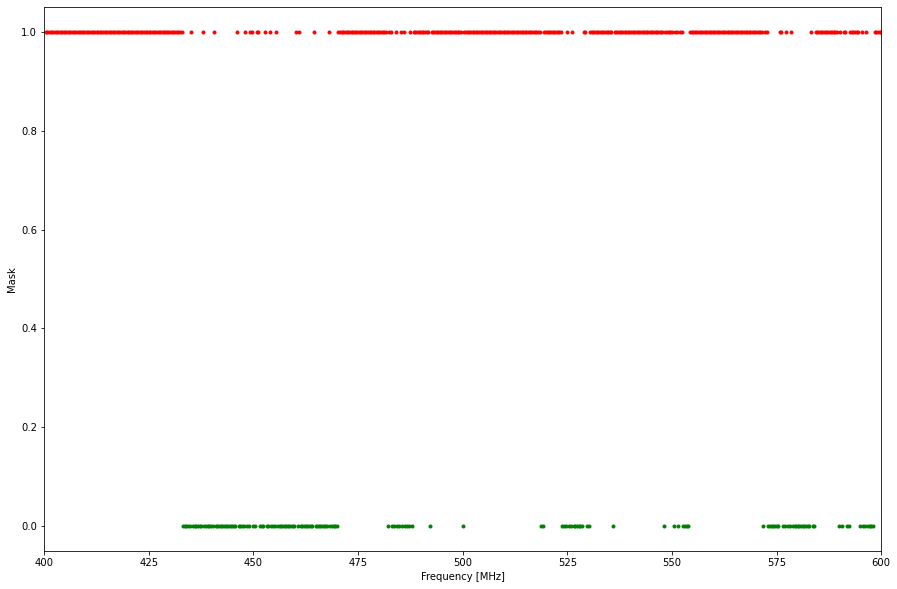

In [13]:
badfreqs = Nbadfreqs + Ebadfreqs

# get unique frequencies per array
uu = np.array(Nbadfreqs)
Nbad_uniq = np.unique(uu)

uu = np.array(Ebadfreqs)
Ebad_uniq = np.unique(uu)

uu = np.array(badfreqs)
bad_uniq = np.unique(uu)

plt.plot(Nbad_uniq)
plt.plot(Ebad_uniq)
plt.plot(bad_uniq)
plt.show()

print(len(Nbad_uniq),len(Ebad_uniq),len(bad_uniq))


freqm = np.zeros(1024)

freqm[bad_uniq] = 1.0

good_uniq = np.where(freqm==0.0)[0][512::]

fig = plt.figure(figsize=(15,10))
plt.plot(freqs[bad_uniq],freqm[bad_uniq],'r.')
plt.plot(freqs[good_uniq],freqm[good_uniq],'g.')
plt.xlim(400,600)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Mask')

print('BAD FREQUENCY INDICES: ',  bad_uniq)
print('GOOD FREQUENCY INDICES: ', good_uniq, len(good_uniq))

print('Good frequencies [MHz]', freqs[good_uniq])

In [28]:
# format into something I can copy paste...

print(repr(good_uniq))


array([517, 518, 519, 520, 522, 523, 525, 532, 533, 536, 538, 553, 554,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
       702, 703, 705, 706, 707, 719, 720, 768, 788, 799, 801, 802, 803,
       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
       932, 933, 935, 936, 937, 938, 939])


In [19]:
old_good = [538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 
            568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 
            599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 
            707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 
            858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 
            877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 
            896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 
            916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 
            931, 932, 933, 935, 938]

print(len(old_good))

125


125 150


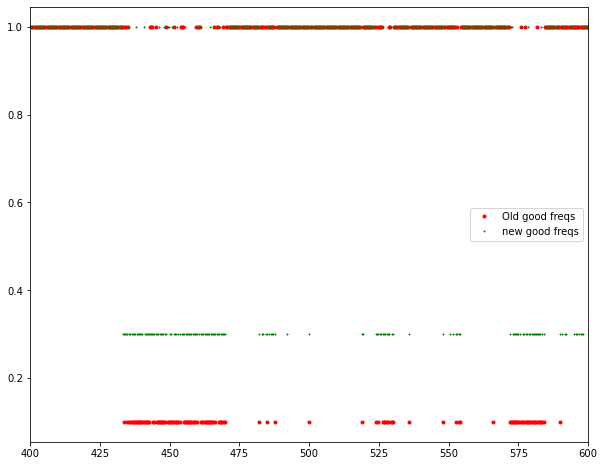

No handles with labels found to put in legend.


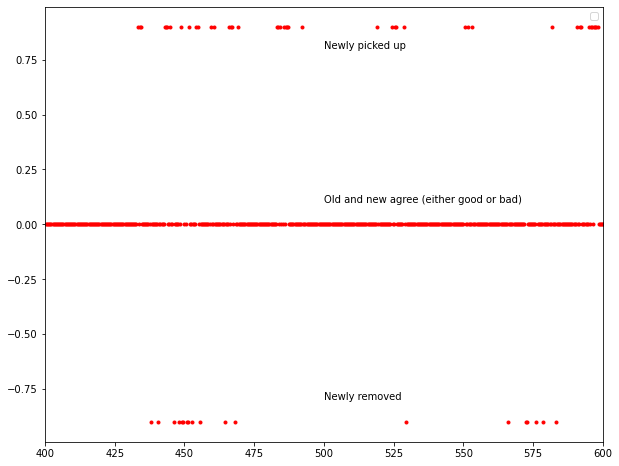

555
567
573
582
583
599
693
850
859
882
889
893
894
897
898
901
906
920
927


In [24]:
print(len(old_good),len(good_uniq))

freqo = np.ones(1024)
freqo[old_good] = 0.1

freqn = np.ones(1024)
freqn[good_uniq] = 0.3

fig = plt.figure(figsize=(10,8))
plt.plot(freqs,freqo,'ro',markersize=3,label='Old good freqs')
plt.plot(freqs,freqn,'g+',markersize=2,label='new good freqs')
plt.xlim(400,600)
plt.legend()
plt.show()

freqo = np.ones(1024)
freqo[old_good] = 0.1

freqn = np.ones(1024)
freqn[good_uniq] = 0.1

fig = plt.figure(figsize=(10,8))
plt.plot(freqs,freqo-freqn,'ro',markersize=3)
plt.xlim(400,600)
plt.text(500,0.8,'Newly picked up')
plt.text(500,-0.8,'Newly removed')
plt.text(500,0.1,'Old and new agree (either good or bad)')
plt.legend()
plt.show()




# are there any frequencies in good old that are bad now?
gg= []
for i,gf in enumerate(old_good):
    if gf not in good_uniq: print(gf)

In [16]:
# compare this with the zeros in the waterfall from the raw data for flight 648

waterfall = [585,586,587, 588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,
  614,  616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,
  629,  641,  643,  644,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,
  657,  658,  659,  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
  671,  672,  673,  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,
  686,  687,  688,  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,
  717,  718,  721,  722,  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,
  733,  734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,
  747,  748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,
  761,  762,  763,  764,  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,
  776,  777,  778,  779,  780,  781,  782,  783,  811,  812,  813,  815,  816,  817,
  818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,
  832,  833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  995,
  996,  998, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

In [17]:
picklezero = [ 540,  541,  542,  543,  544,  545,  546,  550,  552,  574,  585,  586,  587,  588,
  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,  600,  601,  602,  603,
  604,  605,  606,  607,  608,  609,  610,  611,  612,  613,  614,  616,  617,  618,
  619,  620,  621,  622,  623,  624,  625,  626,  627,  628,  629,  638,  641,  643,
  646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
  660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,  671,  672,  673,
  674,  675,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,  687,  688,
  689,  690,  708,  709,  710,  711,  712,  713,  714,  715,  716,  717,  721,  722,
  723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
  737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,  749,  750,
  751,  752,  753,  754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
  765,  766,  767,  769,  770,  771,  772,  773,  774,  775,  776,  777,  778,  779,
  780,  781,  782,  783,  797,  812,  813,  815,  816,  817,  818,  819,  820,  821,
  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,  833,  834,  835,
  836,  837,  838,  839,  840,  841,  842,  843,  844,  934,  936,  938,  939,  940,
  942,  943,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,  956,
  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,  969,  970,
  971,  972,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,  983,  984,
  985,  986,  987,  988,  989,  990,  991,  992,  993,  994,  995,  996,  997,  998,
  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]

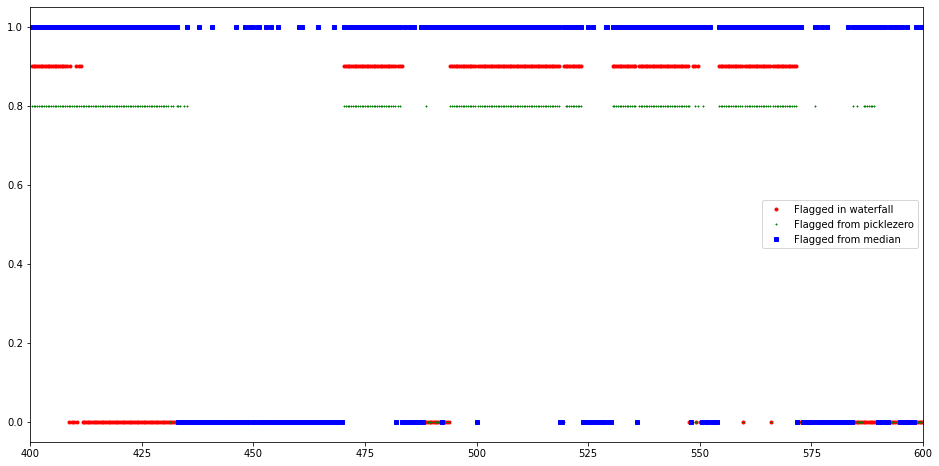

150


In [18]:
freqm = np.zeros(1024)
freqm[bad_uniq] = 1.0

freqw = np.zeros(1024)
freqw[waterfall] = 0.9

freqp = np.zeros(1024)
freqp[picklezero] = 0.8

fig = plt.figure(figsize=(16,8))
plt.plot(freqs,freqw,'ro',markersize=3,label='Flagged in waterfall')
plt.plot(freqs,freqp,'g+',markersize=2,label='Flagged from picklezero')
plt.plot(freqs,freqm,'bs',markersize=4,label='Flagged from median')
plt.xlim(400,600)
plt.legend()
plt.show()

print(len(good_uniq))

In [29]:
# The below is scriptified now in run_slices.py in the scripts directory

#### Playing around with in initial slices to check how well these amplitudes correct things:

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]





In [30]:
pol_input = 'N'
freq_input = 100

In [31]:


# FREQUENCY DEFAULT:
find=896#640#896#992#900#570#800#900
f_intern = int((find-512)/16)
print(freqs[find])

# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

#good_uniq = [518, 519, 522, 523, 535, 538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565,
# 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599,
# 630, 631, 632, 633, 636, 640, 645, 676, 691, 692, 693, 695, 696, 697, 698, 699, 700, 702,
# 703, 705, 706, 707, 720, 768, 799, 801, 807, 811, 814, 845, 846, 848, 849, 850, 851, 854,
# 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 871, 873, 874, 875, 876,
# 877, 878, 879, 880, 881, 882, 883, 886, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897,
# 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920,
# 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938] # files from summer 2023

good_uniq = [517, 518, 519, 520, 522, 523, 525, 532, 533, 536, 538, 553, 554,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 568, 569,
       571, 572, 575, 576, 577, 578, 579, 580, 581, 584, 630, 631, 632,
       633, 636, 639, 645, 676, 691, 692, 695, 696, 697, 698, 699, 700,
       702, 703, 705, 706, 707, 719, 720, 768, 788, 799, 801, 802, 803,
       805, 807, 808, 810, 811, 814, 845, 846, 847, 848, 849, 851, 852,
       853, 854, 855, 856, 857, 858, 860, 861, 862, 863, 864, 865, 866,
       867, 869, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881,
       883, 884, 885, 887, 888, 890, 891, 892, 895, 896, 899, 900, 902,
       903, 904, 905, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931,
       932, 933, 935, 936, 937, 938, 939]

if pol_input == 'N': pflights = Npolflights
else: pflights = Epolflights

find = good_uniq[freq_input]

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(pflights):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',Xargs=[-1*sz,sz,2.5],
                 Yargs=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index=find,vplot=False)

    if fly == '618':
        normarr[:,:,:,i] = 1.0
    elif fly == '620':
        normarr[:,:,:,i] = 1.0
    elif fly in Npolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights[1::]:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]



450.0
618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl'>
start of big ass loop is: 2023-10-13 11:26:43.054967
end of chan/freq loop is: 2023-10-13 11:26:45.694566       


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:329: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)


619 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY619_20211021T185805Z_ver_20231012T010033_concat.pkl'>
start of big ass loop is: 2023-10-13 11:26:50.655398
end of chan/freq loop is: 2023-10-13 11:26:53.937944       
625 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY625_20211021T214028Z_ver_20231012T020905_concat.pkl'>
start of big ass loop is: 2023-10-13 11:26:59.709577
end of chan/freq loop is: 2023-10-13 11:27:03.649629       
646 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 40
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_ver_20231012T022932_concat.pkl
<_io.BufferedReader name='/hirax/GBO_Analysis_Outputs/flight_pickles/FLY646_20211022T183659Z_

In [41]:
print(beam.V_LC_mean.shape)
print(beam.V_LC_mean[:,:,0,chind,0])
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')


(64, 64, 1, 16, 1)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
31


3


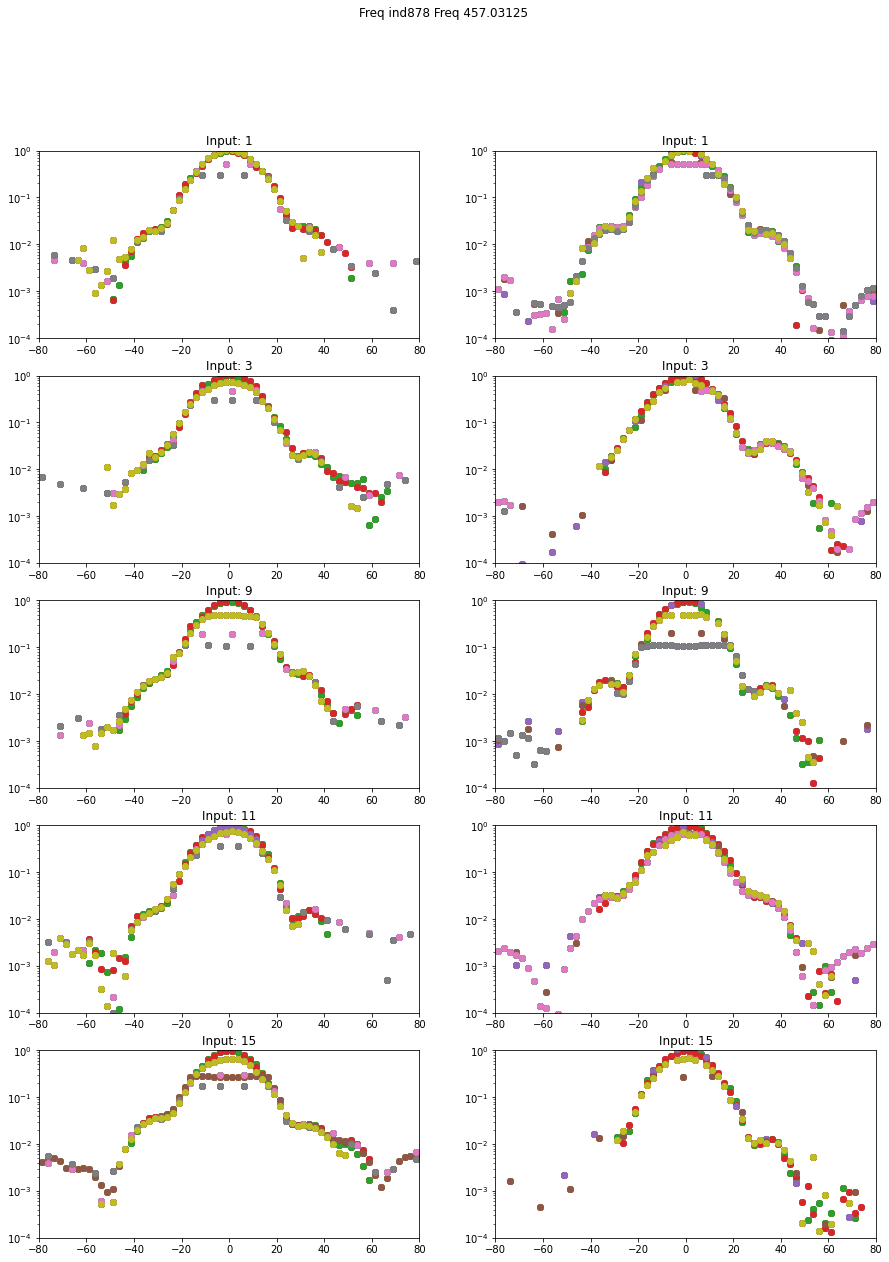

In [44]:
# take slice at x = 0
xx = 0.0
chind = pols[1]
print(chind)
colx = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = get_slice(beam,beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(15,20))
for j, chind in enumerate(pols):
    plt.subplot(5,2,2*j+1)
    for i,p in enumerate(pflights):
        plt.semilogy(beam.y_centers_grid[colx,:,0],flightarr[colx,:,chind],'o',
             label='Flight '+str(p)+'  x :'+str(beam.x_centers_grid[colx,0,0]))
        plt.title('Input: '+str(chind))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
        #plt.legend(loc='lower center')
    plt.subplot(5,2,2*j+2)
    for i,p in enumerate(pflights):
        plt.semilogy(beam.x_centers_grid[:,coly,0],flightarr[:,coly,chind],'o',
             label='Flight '+str(p)+'  y :'+str(beam.y_centers_grid[0,coly,0]))
        plt.ylim(0.0001,1)
        plt.xlim(-1*sz,sz)
        plt.title('Input: '+str(chind))
        #plt.legend(loc='lower center')
plt.suptitle('Freq ind'+str(find)+' Freq '+str(freqs[find]))
plt.show()